# **Machine Problem No. 3: Feature Extraction and Object Detection**

**Step 0.1 Updating OpenCV**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip uninstall opencv-python opencv-contrib-python

Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libavcodec-9aae324f.so.59.37.100
    /usr/loca

In [ ]:
!apt-get update
!apt-get install -y build-essential cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev libtbb2 libtbb-dev libjpeg-dev libpng-dev libtiff-dev libdc1394-22-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,387 kB]
Get:14 http://security.ubuntu.com/ubuntu jam

In [ ]:
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

Cloning into 'opencv'...
remote: Enumerating objects: 336779, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 336779 (delta 32), reused 61 (delta 6), pack-reused 336656 (from 1)
Receiving objects: 100% (336779/336779), 526.61 MiB | 21.89 MiB/s, done.
Resolving deltas: 100% (235041/235041), done.
Updating files: 100% (7566/7566), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 41657, done.
remote: Counting objects: 100% (1407/1407), done.
remote: Compressing objects: 100% (1013/1013), done.
remote: Total 41657 (delta 515), reused 954 (delta 312), pack-reused 40250 (from 1)
Receiving objects: 100% (41657/41657), 150.23 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (25645/25645), done.


In [ ]:
import os
os.makedirs('opencv/build', exist_ok=True)
os.chdir('opencv/build')

!cmake -D CMAKE_BUILD_TYPE=Release \
       -D CMAKE_INSTALL_PREFIX=/usr/local \
       -D OPENCV_EXTRA_MODULES_PATH=../../opencv_contrib/modules \
       -D OPENCV_ENABLE_NONFREE=ON \
       ..

!make -j$(nproc)
!make install


-- The CXX compiler identification is GNU 11.4.0
-- The C compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detected processor: x86_64
-- Found PythonInterp: /usr/bin/python3 (found suitable version "3.10.12", minimum required is "3.2")
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.10.so (found suitable exact version "3.10.12")
-- Looking for ccache - not found
-- Performing Test HAVE_CXX_FSIGNED_CHAR
-- Performing Test HAVE_CXX_FSIGNED_CHAR - Success
-- Performing Test HAVE_C_FSIGNED_CHAR
-- Performing Test HAVE_C_FSIGNED_CHAR - Success
-- Performing Test HAVE_CXX_W
-- Performing 

**Step 0.2 Importing Libraries**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd

**Step 0.3 Initializing accuray calculation**

In [ ]:
# Lowe's ratio test function for feature matching accuracy
def calculate_accuracy(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    accuracy = len(good_matches) / len(matches) if len(matches) > 0 else 0
    return accuracy, len(good_matches)


**Step 0.3 Initializing save paths**

In [ ]:
# Save ipath
save_path = '/content/drive/MyDrive/FeatureMatchingResults'  # Change to your desired path in Google Drive
os.makedirs(save_path, exist_ok=True)

### **Step 1: Load Images**
This step is conducted at the start of each cells/python code

### **Step 2: Extract Keypoints and Descriptors Using SIFT, SURF, and ORB**

**Step 2.1: SIFT Feature Matching**

SIFT detection time: 0.0314 seconds
SIFT number of keypoints: 103 and 119
SIFT accuracy (good matches ratio): 0.1748, good matches: 18


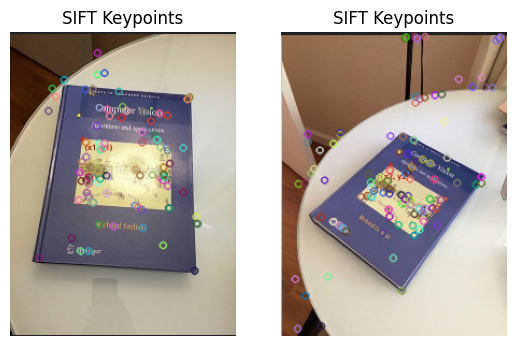

True

In [ ]:
#Load Image
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

#Initialize SIFT Detector
sift = cv2.SIFT_create()

#Detect keypoints and descriptors
start_time = time.time()
keypoints_sift1, descriptors_sift1 = sift.detectAndCompute(gray_image1, None)
keypoints_sift2, descriptors_sift2 = sift.detectAndCompute(gray_image2, None)
sift_time = time.time() - start_time
accuracy_sift, good_matches_sift = calculate_accuracy(descriptors_sift1, descriptors_sift2)
print(f"SIFT detection time: {sift_time:.4f} seconds")
print(f"SIFT number of keypoints: {len(keypoints_sift1)} and {len(keypoints_sift2)}")
print(f"SIFT accuracy (good matches ratio): {accuracy_sift:.4f}, good matches: {good_matches_sift}")

#Draw keypoints on the image
image_sift1_with_keypoints = cv2.drawKeypoints(image1, keypoints_sift1, None)
image_sift2_with_keypoints = cv2.drawKeypoints(image2, keypoints_sift2, None)

#Display the image with keypoints
plt.figuresize = (10, 10)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_sift1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SIFT Keypoints")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_sift2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SIFT Keypoints")
plt.show()

#Save SIFT images
cv2.imwrite(os.path.join(save_path, 'sift_keypoints_image1.jpg'), image_sift1_with_keypoints)
cv2.imwrite(os.path.join(save_path, 'sift_keypoints_image2.jpg'), image_sift2_with_keypoints)

**Step 2.2 SURF Feature Matching**

SURF detection time: 0.0843 seconds
SURF number of keypoints: 402 and 234
SURF accuracy (good matches ratio): 0.0970, good matches: 39


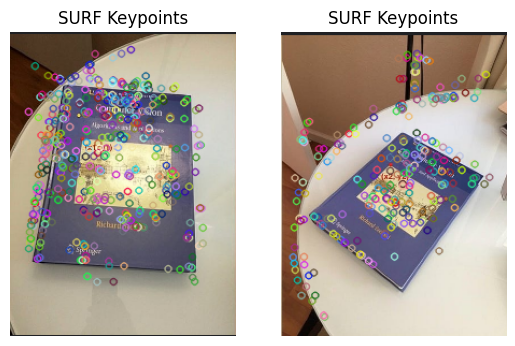

True

In [ ]:
#Load Image
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create()

#Detect keypoints and descriptors
start_time = time.time()
keypoints_surf1, descriptors_surf1 = surf.detectAndCompute(gray_image1, None)
keypoints_surf2, descriptors_surf2 = surf.detectAndCompute(gray_image2, None)
surf_time = time.time() - start_time
accuracy_surf, good_matches_surf = calculate_accuracy(descriptors_surf1, descriptors_surf2)
print(f"SURF detection time: {surf_time:.4f} seconds")
print(f"SURF number of keypoints: {len(keypoints_surf1)} and {len(keypoints_surf2)}")
print(f"SURF accuracy (good matches ratio): {accuracy_surf:.4f}, good matches: {good_matches_surf}")

#Draw keypoints on the image
image_surf1_with_keypoints = cv2.drawKeypoints(image1, keypoints_surf1, None)
image_surf2_with_keypoints = cv2.drawKeypoints(image2, keypoints_surf2, None)

#Display the image with keypoints
plt.figuresize = (10, 10)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_surf1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SURF Keypoints")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_surf2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SURF Keypoints")
plt.show()

#Save SURF images
cv2.imwrite(os.path.join(save_path, 'surf_keypoints_image1.jpg'), image_surf1_with_keypoints)
cv2.imwrite(os.path.join(save_path, 'surf_keypoints_image2.jpg'), image_surf2_with_keypoints)

**Step 2.3 ORB Feature Matching**

ORB detection time: 0.0057 seconds
ORB number of keypoints: 394 and 389
ORB accuracy (good matches ratio): 0.0178, good matches: 7


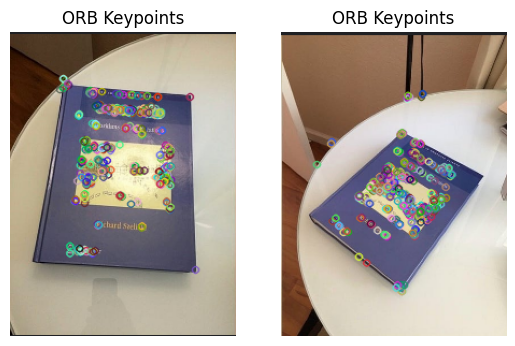

True

In [ ]:
#Load Image
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()

#Detect keypoints and descriptors
start_time = time.time()
keypoints_orb1, descriptors_orb1 = orb.detectAndCompute(gray_image1, None)
keypoints_orb2, descriptors_orb2 = orb.detectAndCompute(gray_image2, None)
orb_time = time.time() - start_time
accuracy_orb, good_matches_orb = calculate_accuracy(descriptors_orb1, descriptors_orb2)
print(f"ORB detection time: {orb_time:.4f} seconds")
print(f"ORB number of keypoints: {len(keypoints_orb1)} and {len(keypoints_orb2)}")
print(f"ORB accuracy (good matches ratio): {accuracy_orb:.4f}, good matches: {good_matches_orb}")

#Draw keypoints on the image
image_orb1_with_keypoints = cv2.drawKeypoints(image1, keypoints_orb1, None)
image_orb2_with_keypoints = cv2.drawKeypoints(image2, keypoints_orb2, None)

#Display the image with keypoints
plt.figuresize = (10, 10)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_orb1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("ORB Keypoints")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_orb2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("ORB Keypoints")
plt.show()

#Save ORB images
cv2.imwrite(os.path.join(save_path, 'orb_keypoints_image1.jpg'), image_orb1_with_keypoints)
cv2.imwrite(os.path.join(save_path, 'orb_keypoints_image2.jpg'), image_orb2_with_keypoints)

### **Step 3: Feature Matching with Brute-Force and FLANN**

**Step 3.1 Feature Matching using Brute Force**

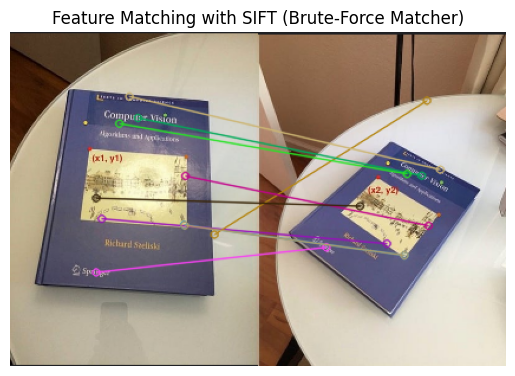

True

In [ ]:
# Load Images
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

# Resize the second image to match the size of the first image
image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Convert to grayscale for feature detection
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2_resized = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_bf1, descriptors_bf1 = sift.detectAndCompute(gray_image1, None)
keypoints_bf2, descriptors_bf2 = sift.detectAndCompute(gray_image2_resized, None)

# Initialize the Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_bf1, descriptors_bf2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches using the original color images, not grayscale
image_matches = cv2.drawMatches(image1, keypoints_bf1, image2_resized, keypoints_bf2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Feature Matching with SIFT (Brute-Force Matcher)")
plt.show()

#Save image
cv2.imwrite(os.path.join(save_path, 'sift_bf_match.jpg'), image_matches)

**Step 3.2 Feature Matching using FLANN**

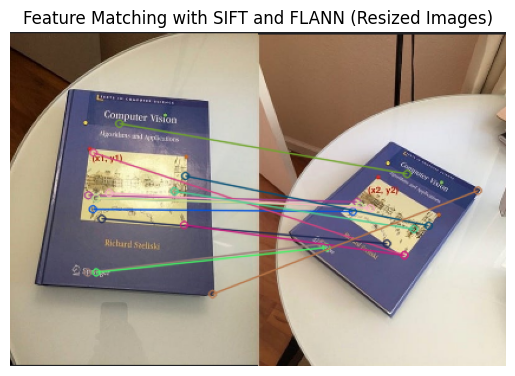

True

In [ ]:

# Load Images
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

# Resize the second image to match the size of the first image
image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Convert to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2_resized = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_flann1, descriptors_flann1 = sift.detectAndCompute(gray_image1, None)
keypoints_flann2, descriptors_flann2 = sift.detectAndCompute(gray_image2_resized, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

f_matches = flann.knnMatch(descriptors_flann1, descriptors_flann2, k=2)

# Apply ratio test
good_matches = []
for m, n in f_matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
image_matches = cv2.drawMatches(image1, keypoints_flann1, image2_resized, keypoints_flann2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Feature Matching with SIFT and FLANN (Resized Images)")
plt.show()

#Save image
cv2.imwrite(os.path.join(save_path, 'sift_flann_match.jpg'), image_matches)

### **Step 4. Image Alignment using Homography**

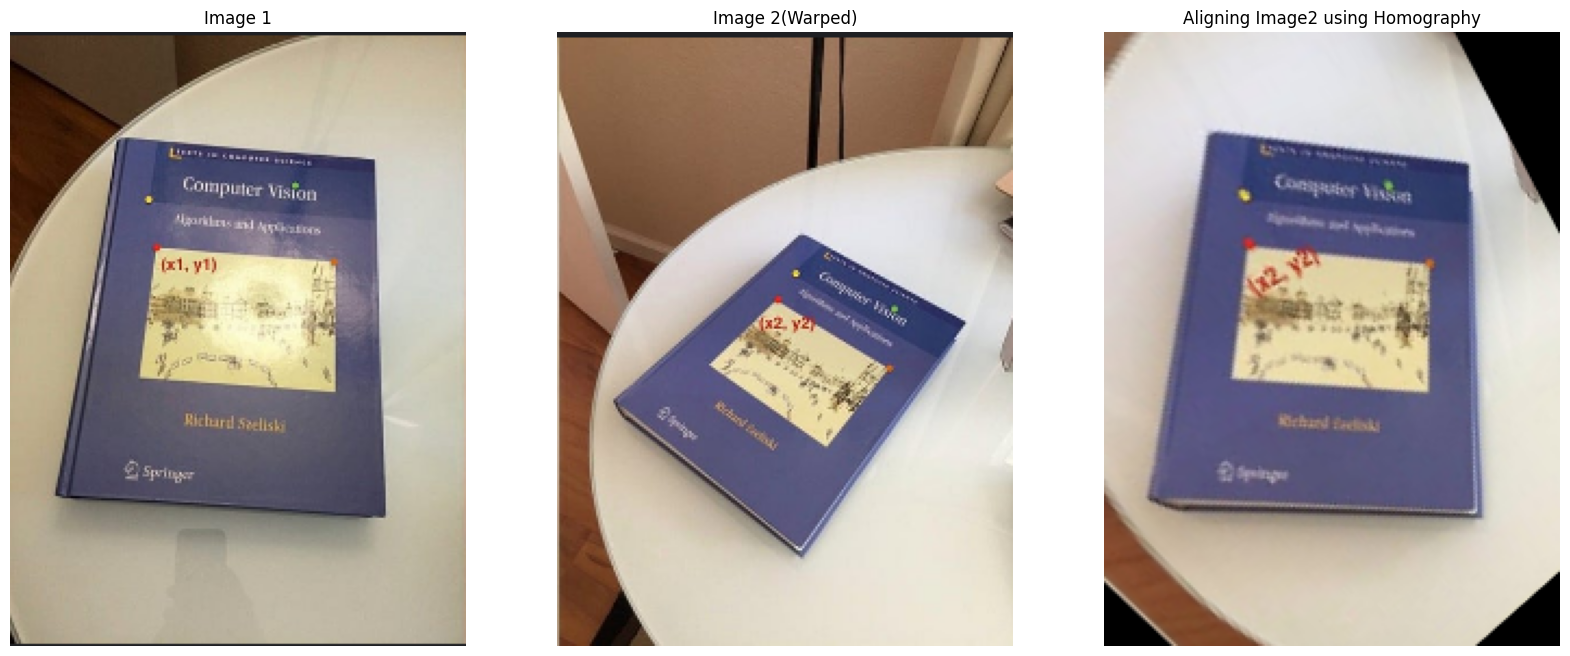

True

In [ ]:
import numpy as np

# Load Images
image1 = cv2.imread("/content/drive/MyDrive/image11_2.png")
image2 = cv2.imread("/content/drive/MyDrive/image11_3.png")

# Convert to Grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Image features using BFmatcher
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test (Lowe's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract location of good matches
src_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
dst_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)

# Find homograpy matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp one image to align with the other
h, w, _= image1.shape
result = cv2.warpPerspective(image2, M, (w, h))

# Display both the original and warped images side by side
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Image 1")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Image 2(Warped)")

# Warped image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligning Image2 using Homography")

plt.show()

#Save image
cv2.imwrite(os.path.join(save_path, 'aligned_image.jpg'), image2)
cv2.imwrite(os.path.join(save_path, 'warped_image.jpg'), result)

### **Step 5: Performance Analysis**

**Step 5.1: Compare the Results**

In [ ]:
data = {
    'Detector': ['SIFT', 'SURF', 'ORB'],
    'Accuracy': [accuracy_sift, accuracy_surf, accuracy_orb],
    'Keypoints': [len(keypoints_sift1), len(keypoints_surf1), len(keypoints_orb1)],
    'Time of feature extraction (s)': [sift_time, surf_time, orb_time]
}
df = pd.DataFrame(data)
print(df)


  Detector  Accuracy  Keypoints  Time of feature extraction (s)
0     SIFT  0.174757        103                        0.037359
1     SURF  0.097015        402                        0.083330
2      ORB  0.017766        394                        0.005968


**Step 5.2 Write a Short Report**

In [ ]:
print('''
The Brute-Force Matcher can be compared with the FLANN Matcher in terms of accuracy
Based on the visualization both produce minimal mistake but BF matcher
made a mistake of features between the book and the table. In comparison to that
FLANN Matcher only made a mistake of matching the corner of the book.
''')


The Brute-Force Matcher can be compared with the FLANN Matcher in terms of accuracy
Based on the visualization both produce minimal mistake but BF matcher
made a mistake of features between the book and the table. In comparison to that
FLANN Matcher only made a mistake of matching the corner of the book.

